In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns
from matplotlib import rcParams
from scipy.interpolate import InterpolatedUnivariateSpline
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})




π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t = 13.78e9               #in units of yrs corresponding to t_0=13.78Gyr
yr = 3.154e7              # in units of seconds
pc = 3.0857e16            # in meters
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of seconds
t_m = 5e9             #in units of yr 
σ_eq = 0.005
ρ_m  = 4e19                #ρ_m=4e19 M☉ Gpc^-3




m1 = np.geomspace(1, 1e5, 10)
m2 = np.geomspace(1e-4, 10, 10)

m_1_list = m1.tolist()
m_2_list = m2.tolist()


Δ_1_list = np.zeros(len(m_1_list))
Δ_2_list = np.zeros(len(m_2_list))



dm = (m_1_list[0] -  m_2_list[0])/2 

for i, (m_1, m_2) in enumerate(zip(m_1_list, m_2_list)):
    Δ_1_list[i] = Δ_2_list[i] = (m_1 + dm)  - (m_2 - dm)
    
# Merger Rate calculations for IMRIPY systems assuming that the DM halos are intact in the merging process.


file = np.load('tmofj0.npz')
ji_ref_list = file['arr_0']
tm_ref_list = file['arr_1']




λ_0 = 1

def s(λ_0): # S_dec of the binary decouple.
    return ((0.03095*λ_0 + 0.3425)*λ_0)
    
def t(λ_0): 
    return ((np.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(λ_0)-2)*np.sqrt(s(λ_0)+1))+(4/3)))
    
g =  InterpolatedUnivariateSpline(tm_ref_list, ji_ref_list, ext = 2) # j_i = g(t_m)
g_prime = g.derivative()




def dP_dX(m_1,m_2,Δ_1,Δ_2, X):
    
    beta = 0.75
    gamma  =  0.65
    delta = -0.89
    a_i_ref = (1e4 * 0.04606)   # in units of pc
    m1_ref = 1      # in units of solar mass.
    m2_ref = 1e-3   # in units of solar mass.

    
    def ρ_bar(m):
        return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 
    
    def M_halo(m,λ_0):
        return (((16*π)/3)*ρ_bar(m)*((2*G*m*(t(λ_0)**2))**(1/4)))
    
    def M(m,λ_0):
        return (m + M_halo(m,λ_0))
    
    def M_binary_initial(m_1,m_2, λ_0):
        return (m_1 + m_2 + M_halo(m_1,λ_0) + M_halo(m_2,λ_0))
      
    def f_(m):
        return f*P(m)
    
    def f_b(m_1,m_2):
        return  f_(m_1)+f_(m_2)
    
    def D(λ_0):
        return ( 1 + 0.4440 * λ_0)/ np.sqrt(1 + 0.0583 * λ_0)
    
    
    
    def j_X(m_1, m_2, Δ_1, Δ_2, X):
        return 0.4045 * np.sqrt(f**2 + 1.2005 * (σ_eq**2))  * np.sqrt((m_1 + m_2)/M_binary_initial(m_1,m_2, λ_0)) * D(λ_0) * (X/(f_b(m_1,m_2) * np.sqrt(Δ_1*Δ_2)))
    
    
    f_pbh = 4.3e-3
    f = 0.85*f_pbh
        
          
    def P(m): #Powerlaw PBH mass distribution
        α = 1.6
        M = 1e-4     #in units of M☉
        return ((α-1)/M) * ((m/M)**(-α))

    def PDF(m):
        return (P(m)/m)

    I = quad(PDF, 1e-4, np.inf)     # Taking limits of the PBH mass from 5 M☉ to 100 M☉ instead of 
                                 # 0 to infinity.
    
    n_T = f*ρ_eq*I[0]            #n_T=f*ρ_eq∫(P(m)/m)*dm 
   
    def x̄(m_1,m_2,Δ_1,Δ_2):
        return (((3*(m_1 + m_2))/(8*π*ρ_eq*f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2)))**(1/3))
    
   
    def λ(m_1,m_2,Δ_1,Δ_2):
        return (8*π*ρ_eq*(x̄(m_1,m_2,Δ_1,Δ_2)**3))/(3*(m_1 + m_2))

    def a_initial(m_1,m_2,Δ_1,Δ_2, X):  # for x = x_bar 
        return (0.0977*λ(m_1,m_2,Δ_1,Δ_2) + 0.0057*(λ(m_1,m_2,Δ_1,Δ_2)**2)) * x̄(m_1,m_2,Δ_1,Δ_2) * (X**(1/3))
    
    
    def C(m_1,m_2,Δ_1,Δ_2, X):
        return ((a_initial(m_1,m_2,Δ_1,Δ_2, X)/a_i_ref)**(beta)) * ((m_1/ m1_ref)**(gamma)) * ((m_2/m2_ref)**(delta))

    
    
   
   
    return  np.exp(- X * ((4*π)/3) * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T)
    
    
        
    

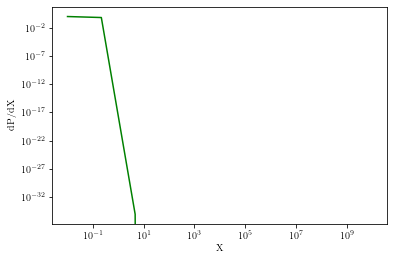

In [35]:
X=np.geomspace(1e-2, 1e10, 10)

X_list = X.tolist()

dP_dX_list = np.zeros(len(X_list))


for i, (m_1,m_2, Δ_1, Δ_2, X) in enumerate(zip(m_1_list, m_2_list, Δ_1_list, Δ_2_list, X_list)):
    dP_dX_list[i] = dP_dX(m_1,m_2,Δ_1,Δ_2, X)
        
plt.loglog(X_list, dP_dX_list, 'g')
plt.xlabel('X')
plt.ylabel('$\mathrm{dP/dX}$')
plt.savefig('dP_dX.pdf')
plt.show()

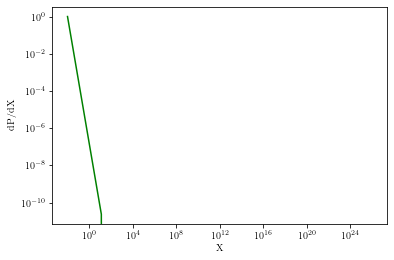

In [36]:
X=np.geomspace(1e-2, 1e26, 10)

X_list = X.tolist()

dP_dX_list = np.zeros(len(X_list))


for i, (m_1,m_2, Δ_1, Δ_2, X) in enumerate(zip(m_1_list, m_2_list, Δ_1_list, Δ_2_list, X_list)):
    dP_dX_list[i] = dP_dX(m_1,m_2,Δ_1,Δ_2, X)
        
plt.loglog(X_list, dP_dX_list, 'g')
plt.xlabel('X')
plt.ylabel('$\mathrm{dP/dX}$')
plt.show()

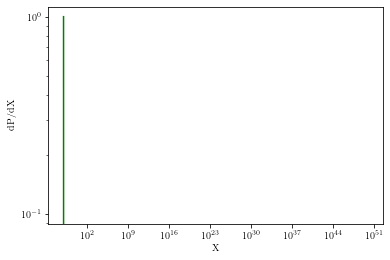

In [37]:
X=np.geomspace(1e-2, 1e50, 10)

X_list = X.tolist()

dP_dX_list = np.zeros(len(X_list))


for i, (m_1,m_2, Δ_1, Δ_2, X) in enumerate(zip(m_1_list, m_2_list, Δ_1_list, Δ_2_list, X_list)):
    dP_dX_list[i] = dP_dX(m_1,m_2,Δ_1,Δ_2, X)
        
plt.loglog(X_list, dP_dX_list, 'g')
plt.xlabel('X')
plt.ylabel('$\mathrm{dP/dX}$')
plt.show()

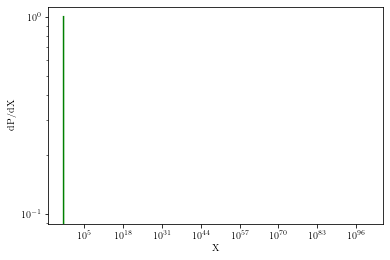

In [38]:
X=np.geomspace(1e-2, 1e100, 10)

X_list = X.tolist()

dP_dX_list = np.zeros(len(X_list))


for i, (m_1,m_2, Δ_1, Δ_2, X) in enumerate(zip(m_1_list, m_2_list, Δ_1_list, Δ_2_list, X_list)):
    dP_dX_list[i] = dP_dX(m_1,m_2,Δ_1,Δ_2, X)
        
plt.loglog(X_list, dP_dX_list, 'g')
plt.xlabel('X')
plt.ylabel('$\mathrm{dP/dX}$')
plt.show()